## Libraries

In [4]:
#Lib import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta


Instructions

Compute daily returns if not already done so

Perform a short exploratory analysis of your data. Discuss the expected values, covariances
and auto-covariances of your returns, How these characteristics change in time? 

In [26]:
def download_stock_data(stock_files, output_dir):
    """
    Download historical stock data using yfinance and save to CSV files.
    
    Parameters:
    stock_files (dict): Dictionary with stock tickers as keys and output filenames as values
    output_dir (str): Directory to save the CSV files
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Calculate date range (for the assignment period)
    start_date = '2021-01-01'  # January 1, 2021
    end_date = '2024-10-25'    # October 25, 2024
    
    # Download data for each ticker
    for ticker, filename in stock_files.items():
        try:
            # Get stock data
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date)
            
            # Save to CSV
            output_path = os.path.join(output_dir, filename)
            df.to_csv(output_path)
            print(f"Successfully downloaded data for {ticker} to {filename}")
            
        except Exception as e:
            print(f"Error downloading data for {ticker}: {str(e)}")

In [58]:

# Define the directory containing your stock data
data_dir = r"C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data" #changable

# Maping tickers, Individual Setting
stock_files = {
    'GOOGL': 'Alphabet A Stock Price History.csv',
    'AMGN': 'Amgen Stock Price History.csv',
    'AVGO': 'Broadcom Stock Price History.csv',
    'DLTR': 'Dollar Tree Stock Price History.csv',
    'ISRG': 'Intuitive Surgical Stock Price History.csv',
    'LULU': 'Lululemon Athletica Stock Price History.csv',
    'QCOM': 'Qualcomm Stock Price History.csv',
    'TXN': 'Texas Instruments Stock Price History.csv',
}

stock_files2 = {
    'SPLK': 'Splunk Stock Price History.csv',
    'TEAM': 'Atlassian Stock Price History.csv',
    'BIDU': 'Baidu Stock Price History.csv',
    'ADBE': 'Adobe Stock Price History.csv',
    'MDLZ': 'Mondelez Stock Price History.csv',
    'AMD': 'AMD Stock Price History.csv',
    'VRSN': 'Verisign Stock Price History.csv',
    'PAYX': 'Paychex Stock Price History.csv',
}

risk_free_file = r'C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\USYields2024.csv'



In [61]:
#Downloading data
stock_data = download_stock_data(stock_files,'stock_data')
stock_data2 = download_stock_data(stock_files2, 'stock_data2')

Successfully downloaded data for GOOGL to Alphabet A Stock Price History.csv
Successfully downloaded data for AMGN to Amgen Stock Price History.csv
Successfully downloaded data for AVGO to Broadcom Stock Price History.csv
Successfully downloaded data for DLTR to Dollar Tree Stock Price History.csv


$SPLK: possibly delisted; no timezone found


Successfully downloaded data for ISRG to Intuitive Surgical Stock Price History.csv
Successfully downloaded data for LULU to Lululemon Athletica Stock Price History.csv
Successfully downloaded data for QCOM to Qualcomm Stock Price History.csv
Successfully downloaded data for TXN to Texas Instruments Stock Price History.csv
Successfully downloaded data for SPLK to Splunk Stock Price History.csv
Successfully downloaded data for TEAM to Atlassian Stock Price History.csv
Successfully downloaded data for BIDU to Baidu Stock Price History.csv
Successfully downloaded data for ADBE to Adobe Stock Price History.csv
Successfully downloaded data for MDLZ to Mondelez Stock Price History.csv
Successfully downloaded data for AMD to AMD Stock Price History.csv
Successfully downloaded data for VRSN to Verisign Stock Price History.csv
Successfully downloaded data for PAYX to Paychex Stock Price History.csv


In [29]:
# Function to calculate daily returns
def calculate_daily_returns(data):
    """
    Calculates daily returns as the logarithm of the ratio of Price to Open prices.
    """
    data['Daily_Return'] = np.log(data['Close'] / data['Open'])
    return data[['Date', 'Daily_Return']]

Loading data into one table and filter 1 Mo risk free rate with the Date


In [54]:
# Load and process stock data
daily_returns = {}
all_data = {}  # Ensure all_data is a dictionary to store data by ticker

for ticker, file_name in stock_files.items():
    file_path = os.path.join(data_dir, file_name)
    print(f"Processing data for {ticker} from {file_path}...")
    data = pd.read_csv(file_path, parse_dates=['Date'])
    data['Ticker'] = ticker  # Add a column for the ticker
    daily_returns[ticker] = calculate_daily_returns(data).set_index('Date')
    all_data[ticker] = data  # Store the full data in the dictionary

# Combine daily returns into a single DataFrame
combined_returns = pd.concat(
    [df['Daily_Return'].rename(ticker) for ticker, df in daily_returns.items()],
    axis=1
)


Processing data for GOOGL from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Alphabet A Stock Price History.csv...
Processing data for AMGN from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Amgen Stock Price History.csv...
Processing data for AVGO from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Broadcom Stock Price History.csv...
Processing data for DLTR from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Dollar Tree Stock Price History.csv...
Processing data for ISRG from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Intuitive Surgical Stock Price History.csv...
Processing data for LULU from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Lululemon Athletica Stock Price History.csv...
Processing data for QCOM from C:\Users\Uzivatel\Documents\ds2-hw\Projekt -AnalyzaInvestic\stock_data\Qualcomm Stock Price History.csv...
Processing data f

In [31]:
risk_free_rate = pd.read_csv(risk_free_file)

# Check the column names and ensure there are no extra spaces
print("\nColumn names:")
print(risk_free_rate.columns)

# Remove leading/trailing spaces from column names
risk_free_rate.columns = risk_free_rate.columns.str.strip()

# Check the first few rows to see the data structure
print("\nFirst few rows of the data:")
print(risk_free_rate.head())

# Ensure the '1 Mo' column is numeric and handle missing values
risk_free_rate['1 Mo'] = pd.to_numeric(risk_free_rate['1 Mo'], errors='coerce')

# Filter only the 'Date' and '1 Mo' columns
if 'Date' in risk_free_rate.columns:
    risk_free_rate = risk_free_rate[['Date', '1 Mo']].dropna()

    # Convert the annualized rate into a daily rate (assuming 252 trading days in a year)
    risk_free_rate['Daily_Risk_Free_Rate'] = (1 + risk_free_rate['1 Mo'] / 100) ** (1 / 252) - 1 #Is this neccesary???

    # Set the 'Date' column as the index for alignment with stock data
    risk_free_rate.set_index('Date', inplace=True)

    print("\nRisk-Free Rate Data (Head):")
    print(risk_free_rate.head())

    # Save the processed risk-free rate for later use
    risk_free_rate.to_csv('processed_risk_free_rate.csv')

    print("Risk-free rate processing complete. File saved as 'processed_risk_free_rate.csv'.")
else:
    print("The 'Date' column is missing or misnamed.")


Column names:
Index(['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', '30 Yr'],
      dtype='object')

First few rows of the data:
         Date  1 Mo  2 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  \
0  02/01/2019  2.40  2.40  2.42  2.51  2.60  2.50  2.47  2.49  2.56   2.66   
1  03/01/2019  2.42  2.42  2.41  2.47  2.50  2.39  2.35  2.37  2.44   2.56   
2  04/01/2019  2.40  2.42  2.42  2.51  2.57  2.50  2.47  2.49  2.56   2.67   
3  07/01/2019  2.42  2.42  2.45  2.54  2.58  2.53  2.51  2.53  2.60   2.70   
4  08/01/2019  2.40  2.42  2.46  2.54  2.60  2.58  2.57  2.58  2.63   2.73   

   20 Yr  30 Yr  
0   2.83   2.97  
1   2.75   2.92  
2   2.83   2.98  
3   2.86   2.99  
4   2.88   3.00  

Risk-Free Rate Data (Head):
            1 Mo  Daily_Risk_Free_Rate
Date                                  
02/01/2019  2.40              0.000094
03/01/2019  2.42              0.000095
04/01/2019  2.40              0.000094
07/01/2019 

Performing exploratory analysis...

Expected Returns (Mean):
GOOGL    0.000619
AMGN    -0.000151
AVGO     0.000412
DLTR    -0.000010
ISRG     0.000072
LULU    -0.000690
QCOM    -0.000180
TXN     -0.000022
dtype: float64

Covariance Matrix:
          GOOGL      AMGN      AVGO      DLTR      ISRG      LULU      QCOM  \
GOOGL  0.000218  0.000030  0.000141  0.000048  0.000121  0.000129  0.000150   
AMGN   0.000030  0.000134  0.000039  0.000044  0.000044  0.000032  0.000036   
AVGO   0.000141  0.000039  0.000364  0.000066  0.000143  0.000161  0.000248   
DLTR   0.000048  0.000044  0.000066  0.000295  0.000058  0.000093  0.000069   
ISRG   0.000121  0.000044  0.000143  0.000058  0.000273  0.000142  0.000148   
LULU   0.000129  0.000032  0.000161  0.000093  0.000142  0.000354  0.000167   
QCOM   0.000150  0.000036  0.000248  0.000069  0.000148  0.000167  0.000359   
TXN    0.000106  0.000043  0.000173  0.000056  0.000101  0.000125  0.000189   

            TXN  
GOOGL  0.000106  
AMGN   0.000

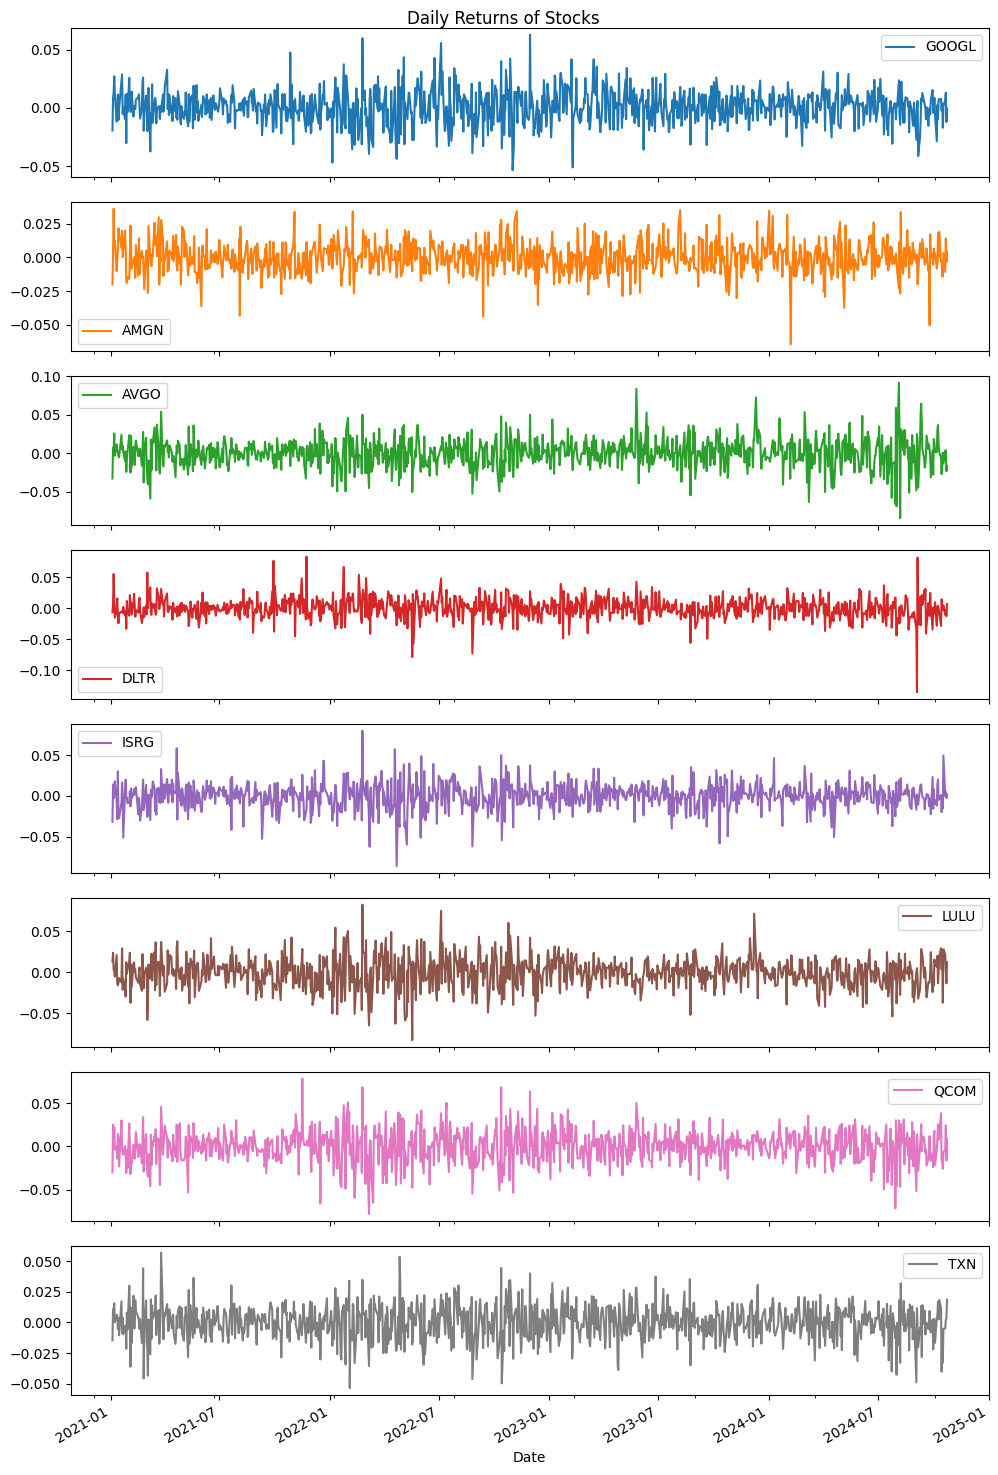


Risk-Free Rate Summary:
              1 Mo  Daily_Risk_Free_Rate
count  1457.000000           1457.000000
mean      2.362848              0.000092
std       2.197106              0.000085
min       0.000000              0.000000
25%       0.090000              0.000004
50%       2.060000              0.000081
75%       4.890000              0.000189
max       6.020000              0.000232
Data processing complete. Files saved as 'daily_returns.csv' and 'risk_free_rate.csv'.


In [57]:
# Exploratory analysis
print("Performing exploratory analysis...")
mean_returns = combined_returns.mean()
cov_matrix = combined_returns.cov()
auto_cov = combined_returns.apply(lambda col: col.autocorr())

print("\nExpected Returns (Mean):")
print(mean_returns)
print("\nCovariance Matrix:")
print(cov_matrix)
print("\nAuto-covariances (Autocorrelations):")
print(auto_cov)

# Plotting daily returns
combined_returns.plot(subplots=True, figsize=(10, 15), title='Daily Returns of Stocks')
plt.tight_layout()
plt.show()

# Summary of Risk-Free Rate
print("\nRisk-Free Rate Summary:")
print(risk_free_rate.describe())

# Save processed data for further analysis
combined_returns.to_csv('daily_returns.csv')
risk_free_rate.to_csv('risk_free_rate.csv')

print("Data processing complete. Files saved as 'daily_returns.csv' and 'risk_free_rate.csv'.")


In [39]:
combined_returns.info()
combined_returns.shape

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 2021-01-04 00:00:00-05:00 to 2024-10-24 00:00:00-04:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGL   959 non-null    float64
 1   AMGN    959 non-null    float64
 2   AVGO    959 non-null    float64
 3   DLTR    959 non-null    float64
 4   ISRG    959 non-null    float64
 5   LULU    959 non-null    float64
 6   QCOM    959 non-null    float64
 7   TXN     959 non-null    float64
dtypes: float64(8)
memory usage: 99.7+ KB


(959, 8)

In [40]:
def explore_data(stock_data):
    """
    Explore the downloaded stock data with various analyses.
    
    Parameters:
    stock_data (dict): Dictionary with stock tickers as keys and pandas DataFrames as values
    """
    print("\n=== Data Exploration ===")
    
    for ticker, df in stock_data.items():
        print(f"\nAnalysis for {ticker}:")
        print("-" * 50)
        
        # Basic info
        print("\nDataset Info:")
        print(df.info())
        
        # Summary statistics
        print("\nSummary Statistics:")
        print(df.describe())
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\nMissing Values:")
            print(missing[missing > 0])
        
        # Calculate daily returns
        df['Daily_Return'] = np.log(df['Close'] / df['Open'])
        
        # Basic metrics
        print("\nKey Metrics:")
        print(f"Total Trading Days: {len(df)}")
        print(f"Average Daily Volume: {df['Volume'].mean():,.0f}")
        print(f"Average Daily Return: {df['Daily_Return'].mean():.4%}")
        print(f"Return Volatility: {df['Daily_Return'].std():.4%}")
        print(f"Maximum Daily Gain: {df['Daily_Return'].max():.4%}")
        print(f"Maximum Daily Loss: {df['Daily_Return'].min():.4%}")
        
        # Plot price history
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Close'])
        plt.title(f'{ticker} Stock Price History')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()
        
        # Plot daily returns distribution
        plt.figure(figsize=(10, 6))
        sns.histplot(df['Daily_Return'], kde=True)
        plt.title(f'{ticker} Daily Returns Distribution')
        plt.xlabel('Daily Return')
        plt.ylabel('Frequency')
        plt.show()

In [63]:
all_data['GOOGL'] #all data in one frame (disctionary)
#combined_returns #This one is more important

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Daily_Return
0,2021-01-04 00:00:00-05:00,87.682146,87.806193,85.048695,85.994766,37324000,0.0,0.0,GOOGL,-0.019432
1,2021-01-05 00:00:00-05:00,85.942956,87.026028,85.534935,86.688255,20360000,0.0,0.0,GOOGL,0.008635
2,2021-01-06 00:00:00-05:00,84.705928,86.883535,84.498680,85.832840,46588000,0.0,0.0,GOOGL,0.013216
3,2021-01-07 00:00:00-05:00,86.026156,88.569936,86.026156,88.396568,41936000,0.0,0.0,GOOGL,0.027182
4,2021-01-08 00:00:00-05:00,88.537051,89.643042,87.742925,89.566818,35484000,0.0,0.0,GOOGL,0.011564
...,...,...,...,...,...,...,...,...,...,...
954,2024-10-18 00:00:00-04:00,163.003193,164.521457,162.893318,163.232925,19757700,0.0,0.0,GOOGL,0.001408
955,2024-10-21 00:00:00-04:00,162.763459,164.311687,162.433835,163.882187,20946500,0.0,0.0,GOOGL,0.006850
956,2024-10-22 00:00:00-04:00,162.793427,165.580242,162.793427,164.950958,16568100,0.0,0.0,GOOGL,0.013166
957,2024-10-23 00:00:00-04:00,164.571388,165.630187,161.744625,162.593658,18280500,0.0,0.0,GOOGL,-0.012090
